In [157]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from bidict import bidict
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [158]:
ENCODER = bidict({
    'a': 1,
    'b': 2,
    'ba': 3, 'be_bi': 4, 'bo_bu': 5,
    'd': 6,
    'da_ra': 7, 'de_di': 8, 'do_du': 9,
    'e_i': 10,
    'g': 11,
    'ga': 12, 'ge_gi': 13, 'go_gu': 14,
    'h': 15,
    'ha': 16, 'he_hi': 17, 'ho_hu': 18,
    'k': 19,
    'ka': 20, 'ke_ki': 21, 'ko_ku': 22,
    'l': 23,
    'la': 24, 'le_li': 25, 'lo_lu': 26,
    'm': 27,
    'ma': 28, 'me_mi': 29, 'mo_mu': 30,
    'n': 31,
    'na': 32, 'ne_ni': 33,
    'ng': 34,
    'nga': 35, 'nge_ngi': 36, 'ngo_ngu': 37, 'no_nu': 38,
    'o_u': 39,
    'p': 40,
    'pa': 41, 'pe_pi': 42, 'po_pu': 43,
    'r': 44,
    'ra': 45, 're_ri': 46, 'ro_ru': 47,
    's': 48,
    'sa': 49, 'se_si': 50, 'so_su': 51,
    't': 52,
    'ta': 53, 'te_ti': 54, 'to_tu': 55,
    'w': 56,
    'wa': 57, 'we_wi': 58, 'wo_wu': 59,
    'y': 60,
    'ya': 61, 'ye_yi': 62, 'yo_yu': 63
})

In [159]:
labels = np.load("../data/labels.npy")
labels = np.array([ENCODER[x] for x in labels]) - 1
labels.shape

(9833,)

In [160]:
imgs = np.load("../data/imgs.npy")
imgs = imgs.astype("float32") / 255
imgs.shape

(9833, 50, 50)

In [161]:
labels

array([ 0,  0,  0, ..., 62, 62, 62])

In [162]:
print(labels.min(), labels.max())  # should be 1 and 63
print(np.unique(labels).shape)     # should be (63,)
print(num_classes)                 # should be 63

0 62
(63,)
63


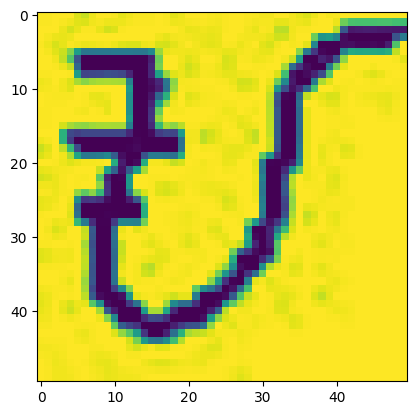

In [163]:
# check out one of the images
plt.figure()
plt.imshow(imgs[0])
plt.grid(False)
plt.show()

In [164]:
imgs = np.expand_dims(imgs, -1)

In [165]:
imgs_train, imgs_test, labels_train, labels_test = train_test_split(
    imgs, labels, test_size=0.30, stratify=labels, random_state=42
)

In [166]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=0.01,
    shear_range=0.05
)
datagen.fit(imgs_train)

In [167]:
batch_size = 8
epochs = 30

model = keras.Sequential([
    keras.Input(shape=(50, 50, 1)),

    # 1st Conv block
    layers.Conv2D(32, kernel_size=3, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.2),
    layers.BatchNormalization(),

    # 2nd Conv block
    layers.Conv2D(64, kernel_size=3, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.2),
    layers.BatchNormalization(),

    # 3rd Conv block
    layers.Conv2D(128, kernel_size=3, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    # Dense output block
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(63, activation="softmax")
])

In [168]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=4, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True)

optimizer = keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [169]:
model.fit(
          datagen.flow(imgs_train, labels_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(imgs_test, labels_test),
          callbacks=[early_stopping, lr_scheduler, checkpoint])

Epoch 1/30


C:\Users\ASUS\Desktop\baybayin-ml\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


861/861 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.1278 - loss: 4.1955 - val_accuracy: 0.4620 - val_loss: 1.7851 - learning_rate: 0.0010
Epoch 2/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4180 - loss: 1.9528 - val_accuracy: 0.4200 - val_loss: 2.1833 - learning_rate: 0.0010
Epoch 3/30
860/861 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5321 - loss: 1.4610
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
861/861 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5321 - loss: 1.4609 - val_accuracy: 0.1820 - val_loss: 3.2719 - learning_rate: 0.0010
Epoch 4/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.6402 - loss: 1.1335 - val_accuracy: 0.6800 - val_loss: 1.0799 - learning_rate: 5.0000e-04
Epoch 5/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.7025 - loss: 0.9550 - val_accuracy: 0.6583 - val_loss: 1.1728 - learning_rate: 5.0000e-04
Epoch 6/30
860/861 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7270 - loss: 0

32 128-3-2 256-3-2 .9102
32 256-3-2 128-3-2 .9077
32 128-3-2 256-3-2 512-3-2 .9127
32 128-1-2 256-3-2 512-5-2 .9327
32 128-5-2 256-5-2 512-5-2 .9626

In [171]:
model.evaluate(imgs_test, labels_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8347 - loss: 0.5863


[0.56873619556427, 0.852203369140625]

In [172]:
labels_pred = np.argmax(model.predict(imgs_test), axis=-1)

cm = confusion_matrix(
    labels_test,
    labels_pred,
    labels=np.arange(1, 63)  # Classes 1 to 63
)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


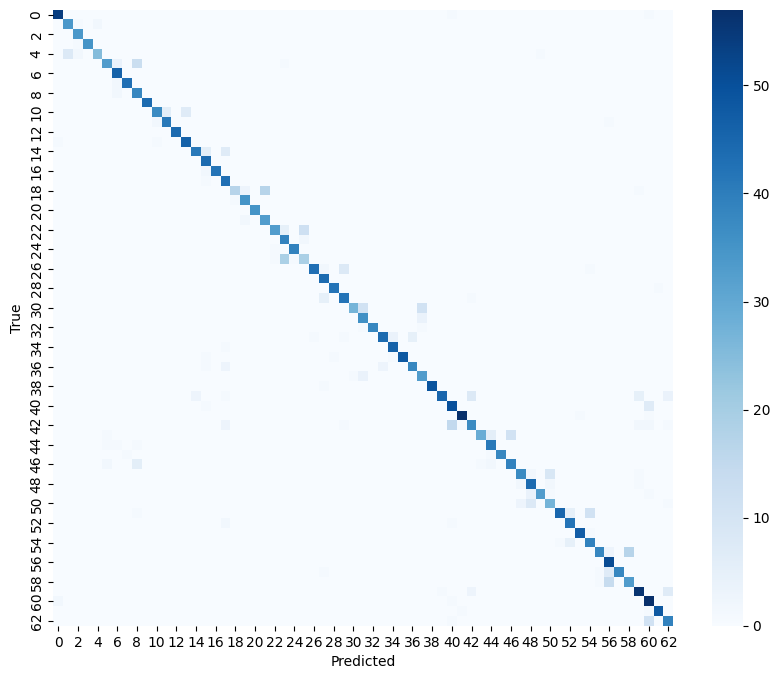

In [173]:

y_pred = model.predict(imgs_test).argmax(axis=1)
cm = confusion_matrix(labels_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [174]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 24, 24, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 9, 9, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 63)                  │          16,191 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,902,015 (7.26 MB)

 Trainable params: 633,855 (2.42 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 1,267,712 (4.84 MB)

In [175]:
unique, counts = np.unique(labels_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Label {u}: {c} samples")

Label 0: 129 samples
Label 1: 86 samples
Label 2: 80 samples
Label 3: 84 samples
Label 4: 84 samples
Label 5: 119 samples
Label 6: 106 samples
Label 7: 106 samples
Label 8: 94 samples
Label 9: 102 samples
Label 10: 117 samples
Label 11: 103 samples
Label 12: 104 samples
Label 13: 112 samples
Label 14: 127 samples
Label 15: 102 samples
Label 16: 102 samples
Label 17: 101 samples
Label 18: 88 samples
Label 19: 85 samples
Label 20: 83 samples
Label 21: 83 samples
Label 22: 115 samples
Label 23: 97 samples
Label 24: 93 samples
Label 25: 95 samples
Label 26: 126 samples
Label 27: 102 samples
Label 28: 102 samples
Label 29: 112 samples
Label 30: 114 samples
Label 31: 95 samples
Label 32: 92 samples
Label 33: 129 samples
Label 34: 109 samples
Label 35: 118 samples
Label 36: 104 samples
Label 37: 89 samples
Label 38: 115 samples
Label 39: 153 samples
Label 40: 135 samples
Label 41: 136 samples
Label 42: 144 samples
Label 43: 111 samples
Label 44: 104 samples
Label 45: 95 samples
Label 46: 115 

In [176]:
model.save("scripts/baybayin_model.keras")

In [177]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 24, 24, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 9, 9, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 63)                  │          16,191 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,902,015 (7.26 MB)

 Trainable params: 633,855 (2.42 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 1,267,712 (4.84 MB)